## Improved cross-entropy, original cross-entropy, and Markov chain Monte Carlo

In [1]:
# numpy is the 'Numerical Python' package
import numpy as np

# Numpy's methods for pseudorandom number generation
import numpy.random as rnd

# We'll use the stats package for p.d.f.s & c.d.f.s
from scipy import stats

# Configure plotting
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

# For progress bars
from tqdm.notebook import trange, tqdm

In [2]:
# Print out the versions of software I'm running
import sys, scipy
print("Python version:", sys.version)
print("Numpy version:", np.__version__)
print("Scipy version:", scipy.__version__)

Python version: 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
Numpy version: 1.18.1
Scipy version: 1.4.1


## Improved cross-entropy method

Use the improved cross-entropy method to estimate $\mathbb{P}(X > \gamma)$ where $X \sim \mathsf{Normal}(0,1)$ and $\gamma=5$. Consider importance sampling distributions of the form $\mathsf{Normal}(\mu, \sigma^2)$.

In [3]:
γ = 5

First, to sample from $g^*(x) = \mathbb{P}(X = x \mid X > \gamma)$, just sample lots of $X$'s 
and extract those $X > \gamma$.

In [4]:
%%time
rng = rnd.default_rng(1337)
R = 5 * 10**8

Xs = rng.normal(size=R)
Xs = Xs[Xs > γ]

print("Number of g* samples:", len(Xs))

Number of g* samples: 152
Wall time: 15.8 s


In [5]:
# Fit our IS proposal distribution to these g* samples
μ = np.mean(Xs)
σ = np.sqrt(np.mean((Xs-μ)**2))

In [6]:
%%time 

# Sample from the new distribution
R = 10**6
normals = rng.normal(μ, σ, R)

# Calculate the likelihood ratios
lrs = stats.norm.pdf(normals, 0, 1) \
    / stats.norm.pdf(normals, μ, σ)

# Construct estimate and CI's
ests = lrs * (normals > γ)
ℓHat = ests.mean()
σHat = ests.std()
widthCI = 1.96 * σHat / np.sqrt(R)

print(f"ICE estimate:\t {ℓHat} (+/- {widthCI})")
print(f"ICE low bound:\t {ℓHat-widthCI}")
print(f"ICE upp bound:\t {ℓHat+widthCI}")
print(f"Theoretical:\t {stats.norm.sf(γ)}")

ICE estimate:	 2.849955479414155e-07 (+/- 8.282676980886911e-10)
ICE low bound:	 2.841672802433268e-07
ICE upp bound:	 2.8582381563950423e-07
Theoretical:	 2.866515718791933e-07
Wall time: 520 ms


## Cross-entropy method 

Use the cross-entropy method to estimate $\mathbb{P}(X > \gamma)$ where $X \sim \mathsf{Normal}(0,1)$ and $\gamma=5$.

In [7]:
%%time

rng = rnd.default_rng(1337)
R = 10**5
ρ = 0.05
maxIter = 50

u = (0, 1)
v = u
vs = [v]

for i in range(maxIter):
    Xs = rng.normal(v[0], v[1], R)
    γ_i = np.quantile(Xs, 1-ρ)
    
    if γ_i >= γ:
        break
    
    eliteXs = Xs[Xs > γ_i]
    eliteLRs = stats.norm.pdf(eliteXs, u[0], u[1]) \
             / stats.norm.pdf(eliteXs, v[0], v[1])
    
    μ_i = np.average(eliteXs, weights=eliteLRs)
    σ_i = np.sqrt(np.average((eliteXs-eliteXs.mean())**2,
                                weights=eliteLRs))
    
    v = (μ_i, σ_i)
    vs.append(v)

Wall time: 62.6 ms


In [8]:
%%time
rng = rnd.default_rng(1)
R = 10**6

# Sample from the new distribution
normals = rng.normal(v[0], v[1], R)

# Calculate the likelihood ratios
lrs = stats.norm.pdf(normals, u[0], u[1]) \
    / stats.norm.pdf(normals, v[0], v[1])

# Construct estimate and CI's
ests = lrs * (normals > γ)
ℓHat = ests.mean()
σHat = ests.std()
widthCI = 1.96 * σHat / np.sqrt(R)

print(f"CE estimate:\t {ℓHat} (+/- {widthCI})")
print(f"CE low bound:\t {ℓHat-widthCI}")
print(f"CE upp bound:\t {ℓHat+widthCI}")
print(f"Theoretical:\t {stats.norm.sf(γ)}")

CE estimate:	 2.8433488092847927e-07 (+/- 1.1057152778688466e-08)
CE low bound:	 2.732777281497908e-07
CE upp bound:	 2.9539203370716776e-07
Theoretical:	 2.866515718791933e-07
Wall time: 845 ms


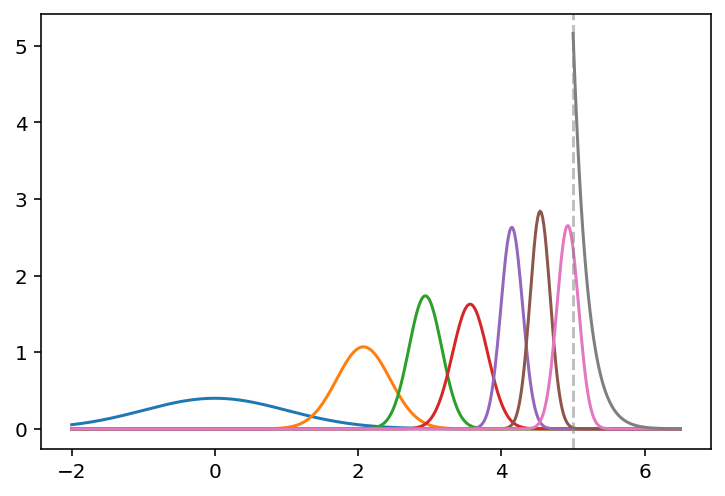

In [9]:
xs = np.linspace(-2, 6.5, 500)
ys = np.empty((len(xs), len(vs)))

for i, v in enumerate(vs):
    ys[:,i] = stats.norm.pdf(xs, v[0], v[1])

plt.plot(xs, ys)

xsOverGamma = xs[xs > γ]
ℓ = stats.norm.sf(γ)
gStar = stats.norm.pdf(xsOverGamma) / ℓ

plt.plot(xsOverGamma, gStar)
plt.gca().axvline(γ, c="grey", ls="dashed", alpha=0.5);

## Compare to crude Monte Carlo

In [10]:
%%time
rng = rnd.default_rng(1337)
R = 10**6

ests = rng.normal(size=R) > γ
ℓHat = ests.mean()
σHat = ests.std()
widthCI = 1.96 * σHat / np.sqrt(R)

print(f"CMC estimate:\t {ℓHat} (+/- {widthCI})")
print(f"CMC low bound:\t {ℓHat-widthCI}")
print(f"CMC upp bound:\t {ℓHat+widthCI}")
print(f"Theoretical:\t {stats.norm.sf(γ)}")

CMC estimate:	 0.0 (+/- 0.0)
CMC low bound:	 0.0
CMC upp bound:	 0.0
Theoretical:	 2.866515718791933e-07
Wall time: 46.8 ms


#### Just do a really _really_ big CMC

In [11]:
from tqdm.notebook import trange, tqdm

In [12]:
%%time
rng = rnd.default_rng(1337)

R = 10**10
reps = 10**4

numExceed = 0
for _ in trange(reps):
    numExceed += np.sum(rng.normal(size=R//reps) > γ)

ℓHat = numExceed / R
σ2Hat = ((R-numExceed)*ℓHat**2 + numExceed*(ℓHat-1)**2)/R
widthCI = 1.96 * np.sqrt(σ2Hat) / np.sqrt(R)

print(f"CMC estimate:\t {ℓHat} (+/- {widthCI})")
print(f"CMC low bound:\t {ℓHat-widthCI}")
print(f"CMC upp bound:\t {ℓHat+widthCI}")
print(f"Theoretical:\t {stats.norm.sf(γ)}")


CMC estimate:	 2.902e-07 (+/- 1.0558560491258553e-08)
CMC low bound:	 2.7964143950874145e-07
CMC upp bound:	 3.0075856049125853e-07
Theoretical:	 2.866515718791933e-07
Wall time: 3min 14s


In [13]:
# For parallel coding
import joblib

In [14]:
%%time

R = 10**10
reps = 10**4
numProcs = 8

sg = rnd.SeedSequence(1)
rngs = [rnd.Generator(rnd.PCG64(s)) for s in sg.spawn(reps)]

def sample_batch(rng, batchSize):
    return np.sum(rng.normal(size=batchSize) > γ)

sample = joblib.delayed(sample_batch)
with joblib.Parallel(n_jobs=numProcs) as parallel:
    numExceedBatchs = parallel(sample(rng, R//reps) for rng in tqdm(rngs))

numExceed = np.sum(numExceedBatchs)

ℓHat = numExceed / R
σ2Hat = ((R-numExceed)*ℓHat**2 + numExceed*(ℓHat-1)**2)/R
widthCI = 1.96 * np.sqrt(σ2Hat) / np.sqrt(R)

print(f"CMC estimate:\t {ℓHat} (+/- {widthCI})")
print(f"CMC low bound:\t {ℓHat-widthCI}")
print(f"CMC upp bound:\t {ℓHat+widthCI}")
print(f"Theoretical:\t {stats.norm.sf(γ)}")


CMC estimate:	 2.856e-07 (+/- 1.0474543649490558e-08)
CMC low bound:	 2.7512545635050947e-07
CMC upp bound:	 2.9607454364949056e-07
Theoretical:	 2.866515718791933e-07
Wall time: 56.8 s


## Cross-entropy, insurance example

We model an insurer's risk reserve process $R(t)$ as

$$ R(t) = R(0) + p t - \sum_{i=1}^{N_t} U_i $$

where $R(0) \ge 0$, $p > 0$, $N_t$ is a Poisson process with intensity $\lambda$ and $U_i \overset{\mathrm{i.i.d.}}{\sim} \mathsf{Lognormal}(\mu, \sigma^2)$, i.e. $\log(U_i) \overset{\mathrm{i.i.d.}}{\sim} \mathsf{Normal}(\mu, \sigma^2)$. 

Estimate 

$$\mathbb{P}(\text{Ruin after first claim})
= \mathbb{P}(R(T_1) < 0)
$$

using the cross-entropy method. Note

$$ R(T_1) = R(0) + p T_1 - U_1 $$

where $T_1 \sim \mathsf{Exponential}(\lambda)$, $U_1 \sim \mathsf{Lognormal}(\mu, \sigma^2)$. Use the CE method to find the best $\lambda$ and $\mu$ values for an importance sampling estimate. 

In [15]:
R_0 = 1.05
p = 20
λ = 0.1
μ = 0.01
σ = 0.01

First try with crude Monte Carlo.

In [16]:
%%time 

rng = rnd.default_rng(1)

R = 10**10
reps = 10**4

numProcs = 8
sg = rnd.SeedSequence(1)
rngs = [rnd.Generator(rnd.PCG64(s)) for s in sg.spawn(reps)]

def sample_batch(rng, batchSize):
    T_1 = rng.exponential(scale=1/λ, size=batchSize)
    U_1 = rng.lognormal(μ, σ, size=batchSize) 
    R_T1 = R_0 + p * T_1 - U_1
    return np.sum(R_T1 < 0)

sample = joblib.delayed(sample_batch)
with joblib.Parallel(n_jobs=numProcs) as parallel:
    numExceedBatchs = parallel(sample(rng, R//reps) for rng in tqdm(rngs))

numExceed = np.sum(numExceedBatchs)

ℓHat = numExceed / R
σ2Hat = ((R-numExceed)*ℓHat**2 + numExceed*(ℓHat-1)**2)/R
widthCI = 1.96 * np.sqrt(σ2Hat) / np.sqrt(R)

print(f"CMC estimate:\t {ℓHat} (+/- {widthCI})")
print(f"CMC low bound:\t {ℓHat-widthCI}")
print(f"CMC upp bound:\t {ℓHat+widthCI}")


CMC estimate:	 7e-10 (+/- 5.185672567871612e-10)
CMC low bound:	 1.8143274321283874e-10
CMC upp bound:	 1.218567256787161e-09
Wall time: 2min 40s


Run the cross-entropy method by adjusting the $\lambda$ parameter of the $\mathsf{Exponential}(\lambda)$ interarrival time and the $\mu$ parameter of the first claim size distribution $\mathsf{Lognormal}(\mu, \sigma^2)$. 

In [17]:
%%time 

rng = rnd.default_rng(420)
R = 10**5
ρ = 0.25
maxCEIter = 50 

u = (λ, μ)
v = u
vs = [v]

for i in range(maxCEIter):
    T_1 = rng.exponential(scale=1/v[0], size=R)
    U_1 = rng.lognormal(v[1], σ, size=R) 
    R_T1 = R_0 + p * T_1 - U_1

    γ_i = np.quantile(R_T1, ρ)
    print(f"v: {v} γ_i: {γ_i}")
    
    if γ_i <= 0:
        break
    
    isElite = R_T1 < γ_i
    eliteT_1 = T_1[isElite]
    eliteLogU_1 = np.log(U_1[isElite])
    
    eliteLRs = stats.expon.pdf(eliteT_1, scale=1/u[0]) \
        / stats.expon.pdf(eliteT_1, scale=1/v[0]) \
        * stats.norm.pdf(eliteLogU_1, loc=u[1], scale=σ) \
        / stats.norm.pdf(eliteLogU_1, loc=v[1], scale=σ)
    
    λ_next = 1 / (np.sum(eliteT_1 * eliteLRs) / np.sum(eliteLRs))
    μ_next = np.sum(eliteLogU_1 * eliteLRs) / np.sum(eliteLRs)
    v = (λ_next, μ_next)
    
    vs.append(v)

v: (0.1, 0.01) γ_i: 57.60442992893887
v: (0.7285734445306061, 0.009959251618470763) γ_i: 7.8280805641190865
v: (5.143618825696992, 0.010123713428265789) γ_i: 1.1608667527372012
v: (35.63921514422642, 0.010077820390754874) γ_i: 0.20074767179652492
v: (246.3982043229073, 0.010601895202341075) γ_i: 0.06326150037464986
v: (1438.9338780860937, 0.014315165370403836) γ_i: 0.03777713850351716
v: (3345.9108503436755, 0.023842310396743602) γ_i: 0.023804011079325227
v: (5043.496453044602, 0.033497557317738444) γ_i: 0.01240804018480135
v: (6704.950123400078, 0.042650054243570275) γ_i: 0.002046790321834302
v: (8287.745938629256, 0.051446202692242524) γ_i: -0.007703110775777122
Wall time: 109 ms


In [18]:
%%time 

R = 10**6
rng = rnd.default_rng(1)
    
T_1 = rng.exponential(scale=1/v[0], size=R)
U_1 = rng.lognormal(v[1], σ, size=R) 
R_T1 = R_0 + p * T_1 - U_1

ruin = R_T1 < 0
ruinT_1 = T_1[ruin]
ruinLogU_1 = np.log(U_1[ruin])

LRs = np.zeros(len(ruin))
LRs[ruin] = stats.expon.pdf(ruinT_1, scale=1/u[0]) \
    / stats.expon.pdf(ruinT_1, scale=1/v[0]) \
    * stats.norm.pdf(ruinLogU_1, loc=u[1], scale=σ) \
    / stats.norm.pdf(ruinLogU_1, loc=v[1], scale=σ)

ests = ruin * LRs

# Construct estimate and CI's
ℓHat = ests.mean()
σHat = ests.std()
widthCI = 1.96 * σHat / np.sqrt(R)

print(f"CE estimate:\t {ℓHat} (+/- {widthCI})")
print(f"CE low bound:\t {ℓHat-widthCI}")
print(f"CE upp bound:\t {ℓHat+widthCI}")

CE estimate:	 6.390450834187833e-10 (+/- 2.7254597818147374e-12)
CE low bound:	 6.363196236369685e-10
CE upp bound:	 6.41770543200598e-10
Wall time: 282 ms


## Markov chain Monte Carlo

#### Sampling Laplace distribution 

$$ X \sim \mathsf{Laplace}(\mu, \lambda) \quad \Rightarrow \quad f_X(x) = \frac{1}{2\lambda} \exp \,\Bigl\{- \frac{| x - \mu | }{\lambda} \Bigr\} $$

Let's sample from $\mathsf{Laplace}(0, 1)$, so

$$ \pi(x) \propto \exp \,\{- | x | \} \,. $$

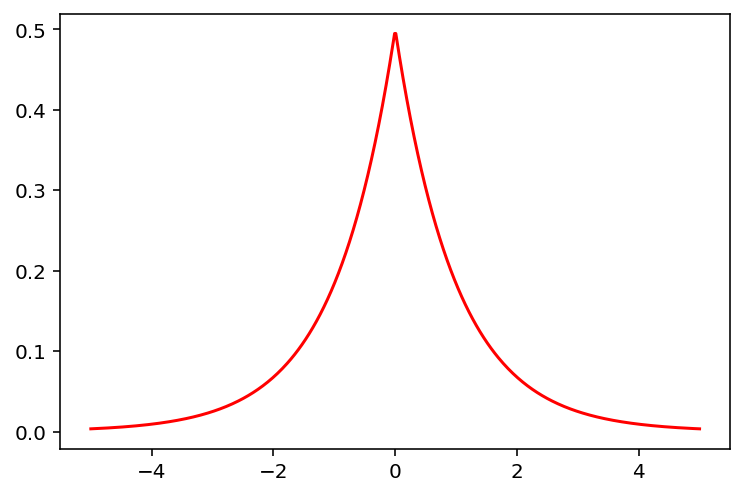

In [19]:
xs = np.linspace(-5,5, 500)
plt.plot(xs, stats.laplace.pdf(xs), 'r');

Use a random walk sampler to sample from this density. Proposals are made by adding normal random variables to the current point.

In [20]:
%%time 

rng = rnd.default_rng(1)
R = 10**5

π = lambda x: np.exp(-np.abs(x))

X = np.empty(R)
X[0] = 0

for n in trange(1, R):
    Y = X[n-1] + rng.normal()
    
    α = π(Y) / π(X[n-1])
    
    if rng.uniform() < α:
        X[n] = Y
    else:
        X[n] = X[n-1]


Wall time: 1.16 s


Compare the samples histogram against the target density. 

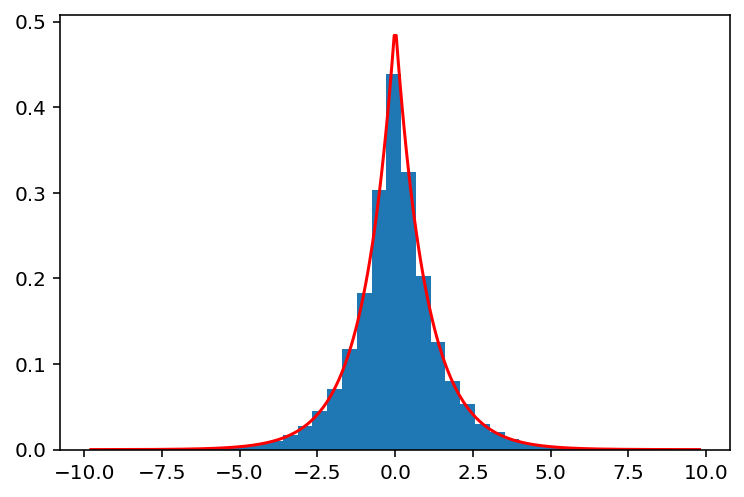

In [21]:
xlim = np.max(np.abs(X))
xs = np.linspace(-xlim, xlim, 300)
plt.plot(xs, stats.laplace.pdf(xs), 'r')
plt.hist(X, 40, density=True);

#### Sampling truncated Weibull distribution  

$$ X \sim \mathsf{Weibull}(k) \quad \Rightarrow \quad f_X(x) = k x^{k-1} \exp \{- x^k  \} $$

for all $x > 0$. Let's sample from $X \sim \mathsf{Weibull}(\frac12)$ conditioned on $\{ a \le X \le b \}$, so


$$ \pi(x) \propto 1\{a \le x \le b\} \cdot x^{-\frac12} \exp \{- x^{\frac12} \} \,. $$

For example, this could be used to model claim sizes for an insurer. Claims which are too small wouldn't be processed, and similarly claims which are too big are passed onto the reinsurer.

In [22]:
a = 10
b = 50

In [23]:
π = lambda x: (x >= a) * (x <= b) * 0.5 * x**(-0.5) * np.exp(-x**(0.5))
πConst = (stats.weibull_min.cdf(b, c=0.5) \
        - stats.weibull_min.cdf(a, c=0.5))

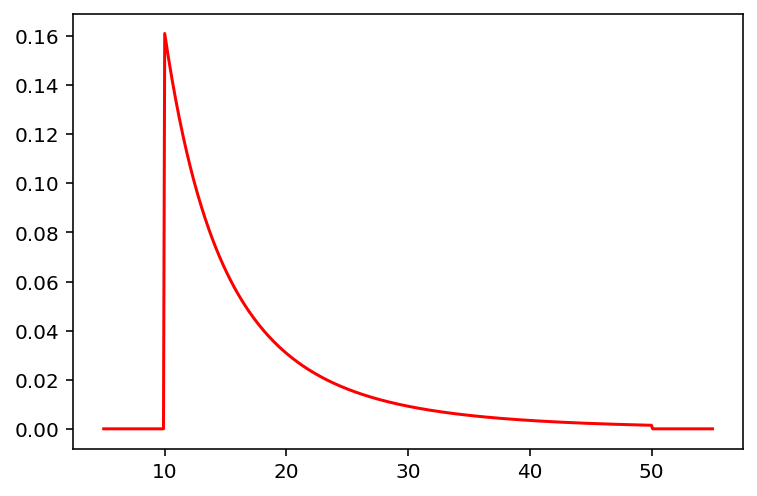

In [24]:
x = np.linspace(a/2, b*1.1, 500)
plt.plot(x, π(x) / πConst, 'r');

In [25]:
%%time 

rng = rnd.default_rng(1)
R = 10**6

X = np.empty(R)
X[0] = 25

jumps = rng.normal(size=R-1)
uniforms = rng.uniform(size=R-1)

for n in trange(1, R):
    Y = X[n-1] + jumps[n-1]
    
    α = π(Y) / π(X[n-1])
    
    if uniforms[n-1] < α:
        X[n] = Y
    else:
        X[n] = X[n-1]


Wall time: 14.7 s


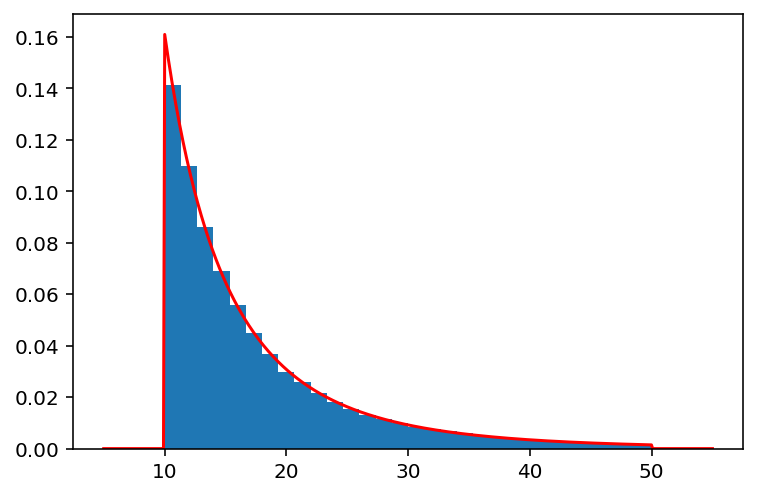

In [26]:
x = np.linspace(a/2, b*1.1, 500)
plt.plot(x, π(x) / πConst, 'r')
plt.hist(X, 30, density=True);

### Possible problem: Starting value invalid

In [27]:
%%time
rng = rnd.default_rng(1)
R = 10**3

X = np.empty(R)
X[0] = b + 10

for n in trange(1, R):
    Y = X[n-1] + rng.normal()
    
    α = π(Y) / π(X[n-1])
    
    if rng.uniform() < α:
        X[n] = Y
    else:
        X[n] = X[n-1]


Wall time: 44 ms


C:\Users\patri\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


In [28]:
X[:10]

array([60., 60., 60., 60., 60., 60., 60., 60., 60., 60.])

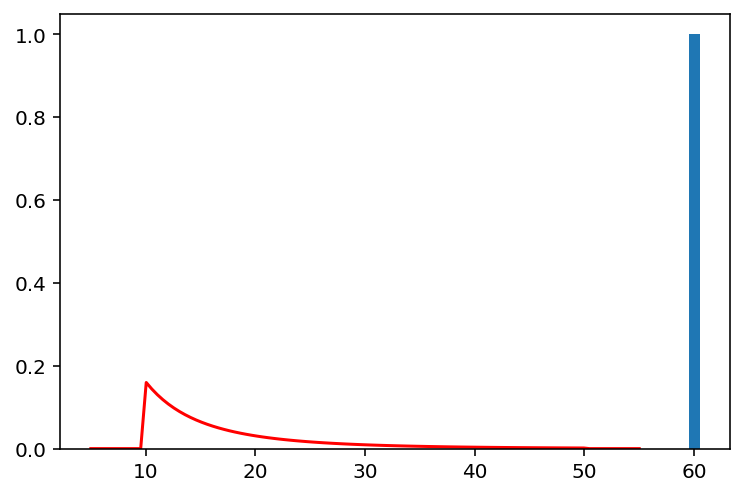

In [29]:
x = np.linspace(a/2, b*1.1, 100)
plt.plot(x, π(x) / πConst, 'r')
plt.hist(X, 1, density=True);

In [30]:
Y = X[0] + rng.normal()
α = π(Y) / π(X[0])
accept = rng.uniform() < α
print(f"Propos {Y}, accept w.p. {α} = {π(Y)} / {π(X[0])}, accepted = {accept}")

Propos 61.232831391763376, accept w.p. nan = 0.0 / 0.0, accepted = False


C:\Users\patri\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


### Possible problem: Starting value unlikely

Consider $X \sim \mathsf{Weibull}(\frac12)$ conditioned on $\{ X \ge a\}$ (so no right truncation), but start the MC at some huge value $X_0 = 1000$.

In [31]:
π = lambda x: (x >= a) * 0.5 * x**(-0.5) * np.exp(-x**0.5) 
πConst = stats.weibull_min.sf(a, c=0.5)

In [32]:
rng = rnd.default_rng(1)
R = 10**5

X = np.empty(R)
X[0] = 10**3

for n in trange(1, R):
    Y = X[n-1] + rng.normal()
    
    α = π(Y) / π(X[n-1])
    
    if rng.uniform() < α:
        X[n] = Y
    else:
        X[n] = X[n-1]

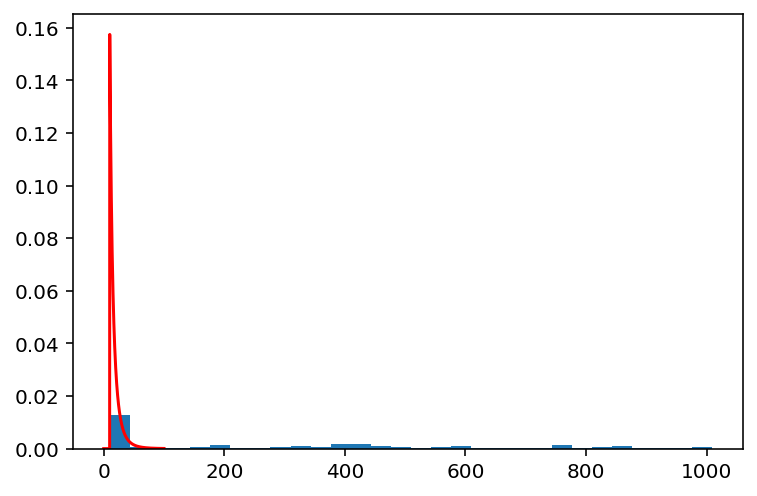

In [33]:
x = np.linspace(1e-10, 100, 500)
plt.hist(X, 30, density=True);
plt.plot(x, π(x) / πConst, 'r');

Plot the samples as a time-series to diagnose the problem.

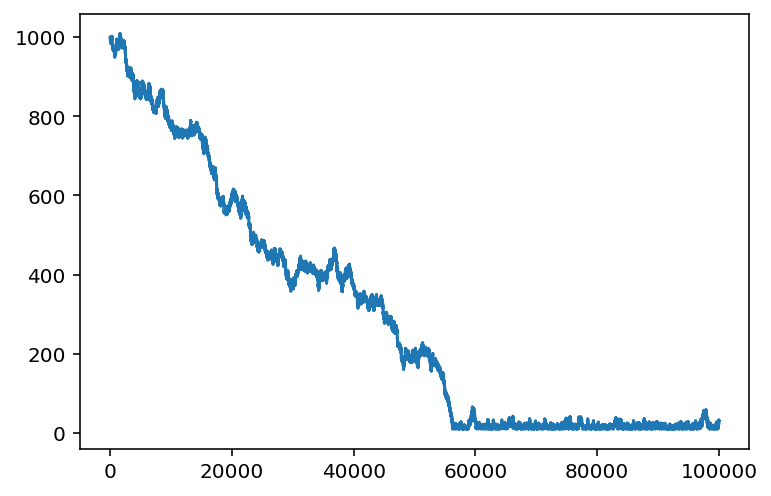

In [34]:
plt.plot(X);

Throw away the first part, called the _burn in_ or _warm up_ period.

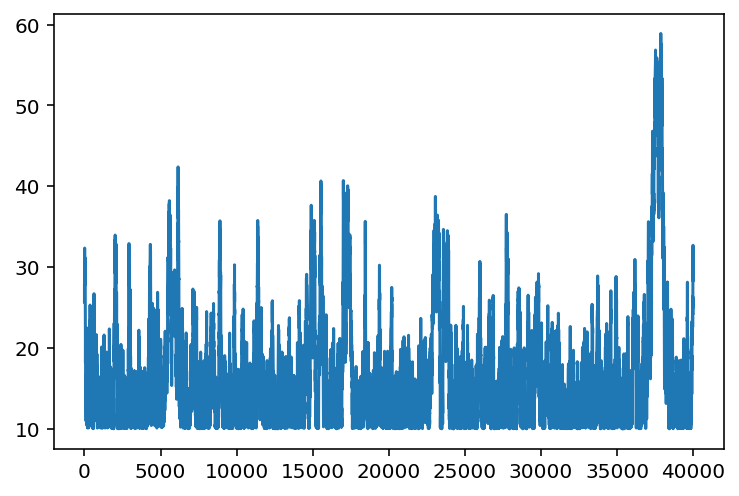

In [35]:
plt.plot(X[60000:]);

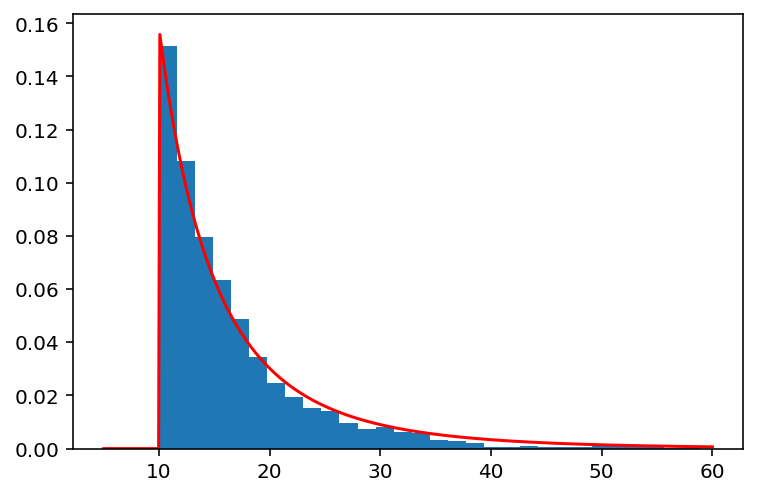

In [36]:
x = np.linspace(a/2, 60, 500)
plt.hist(X[60000:], 30, density=True);
plt.plot(x, π(x) / πConst, 'r');

Better solution is to start many chains in different places and check that they all converge to the same region.

In [37]:
rng = rnd.default_rng(1)
R = 10**4
nchains = 4

X = np.empty((nchains, R))

for c in trange(nchains):

    X[c,0] = 10 + 100 * c 

    for n in range(1, R):
        Y = X[c,n-1] + rng.normal()

        α = π(Y) / π(X[c,n-1])

        if rng.uniform() < α:
            X[c,n] = Y
        else:
            X[c,n] = X[c,n-1]

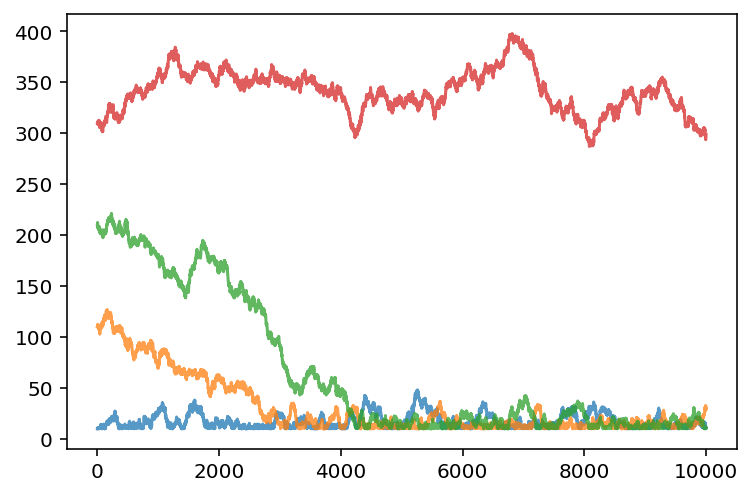

In [38]:
plt.plot(X.T, alpha=0.75);

Three of the chains converged to stationary by about sample 4000. The red one still needs more time to burn in.

If we try again with smaller starting values we should converge faster.

In [39]:
rng = rnd.default_rng(1)
R = 10**4
nchains = 4

X = np.empty((nchains, R))

for c in trange(nchains):

    X[c,0] = 10 + 10 * c 

    for n in range(1, R):
        Y = X[c,n-1] + rng.normal()

        α = π(Y) / π(X[c,n-1])

        if rng.uniform() < α:
            X[c,n] = Y
        else:
            X[c,n] = X[c,n-1]

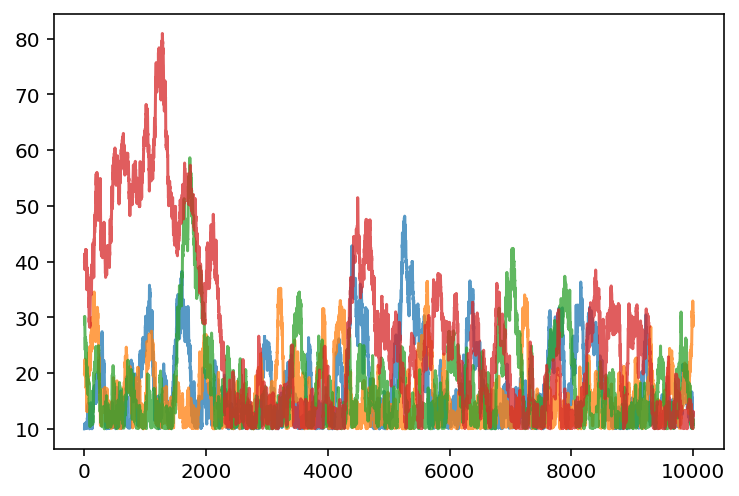

In [40]:
plt.plot(X.T, alpha=0.75);

In [41]:
X = X[:,2000:].reshape(-1)
X.shape

(32000,)

#### Possible problem: dependence

Let's return to sampling $X \sim \mathsf{Weibull}(\frac12)$ conditioned on $\{ a \le X \le b \}$.

In [42]:
π = lambda x: (x >= a) * (x <= b) * 0.5 * x**(-0.5) * np.exp(-x**(0.5))
πConst = (stats.weibull_min.cdf(b, c=0.5) \
        - stats.weibull_min.cdf(a, c=0.5))

In [43]:
%%time 

rng = rnd.default_rng(1)
R = 10**3

X = np.empty(R)
X[0] = 25

jumps = rng.normal(size=R-1)
uniforms = rng.uniform(size=R-1)

for n in trange(1, R):
    Y = X[n-1] + jumps[n-1]
    
    α = π(Y) / π(X[n-1])
    
    if uniforms[n-1] < α:
        X[n] = Y
    else:
        X[n] = X[n-1]


Wall time: 31.2 ms


In [44]:
import arviz as az

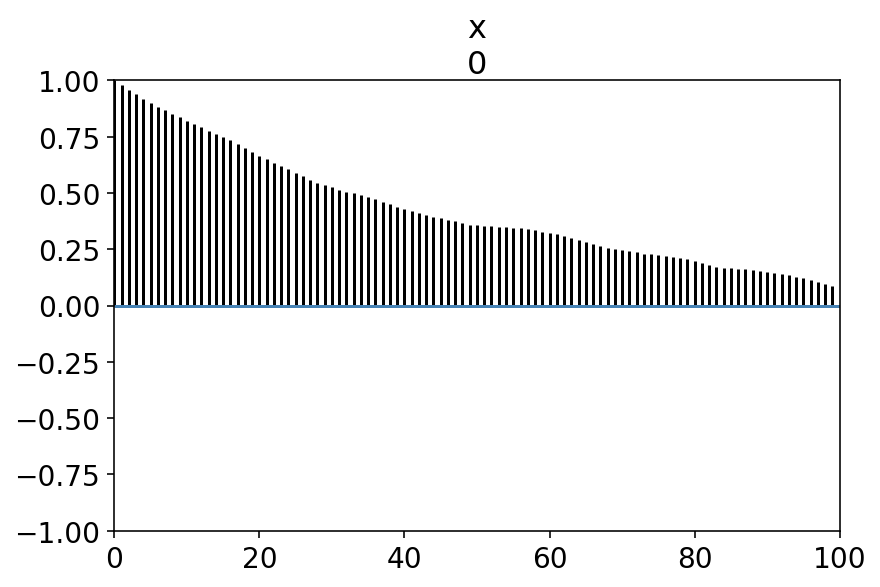

In [45]:
az.plot_autocorr(X);

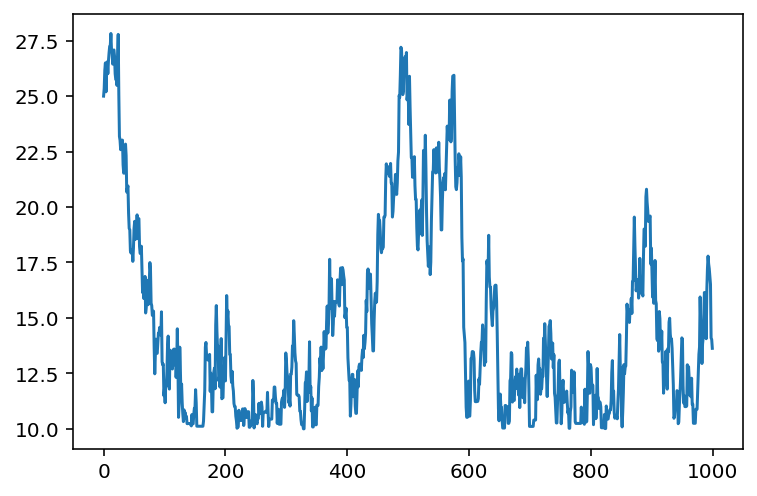

In [46]:
plt.plot(X);

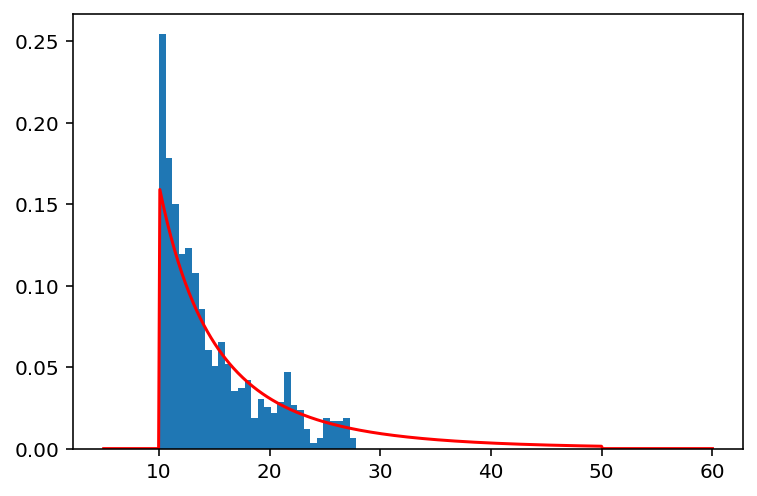

In [47]:
xs = np.linspace(a/2, 60, 500)
plt.hist(X, 30, density=True);
plt.plot(xs, π(xs) / πConst, 'r');

In [48]:
acceptRate = np.mean(np.diff(X) != 0.0)
print(f"We accepted {acceptRate*100:.2f}% of proposals")

We accepted 84.88% of proposals


In [49]:
az.stats.ess(X)

16.835607048346276

In [50]:
%%time 

rng = rnd.default_rng(1)
R = 10**3

X = np.empty(R)
X[0] = 25

jumps = rng.normal(scale=20, size=R-1)
uniforms = rng.uniform(size=R-1)

for n in trange(1, R):
    Y = X[n-1] + jumps[n-1]
    
    α = π(Y) / π(X[n-1])
    
    if uniforms[n-1] < α:
        X[n] = Y
    else:
        X[n] = X[n-1]
        
acceptRate = np.mean(np.diff(X) != 0.0)
print(f"We accepted {acceptRate*100:.2f}% of proposals")


We accepted 27.63% of proposals
Wall time: 62.4 ms


C:\Users\patri\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


In [51]:
az.stats.ess(X)

89.15734704219965

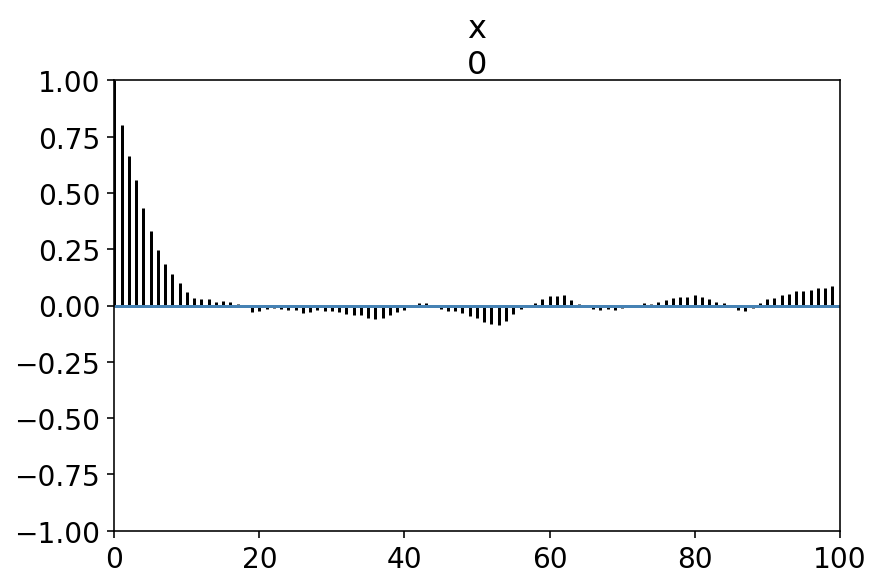

In [52]:
az.plot_autocorr(X);

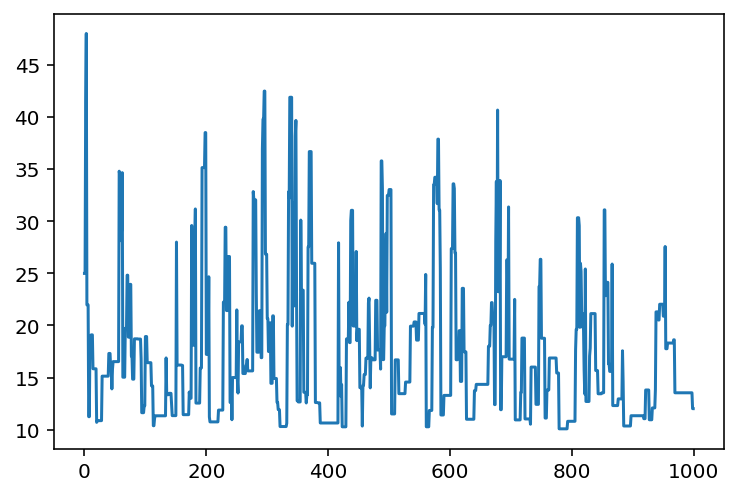

In [53]:
plt.plot(X);

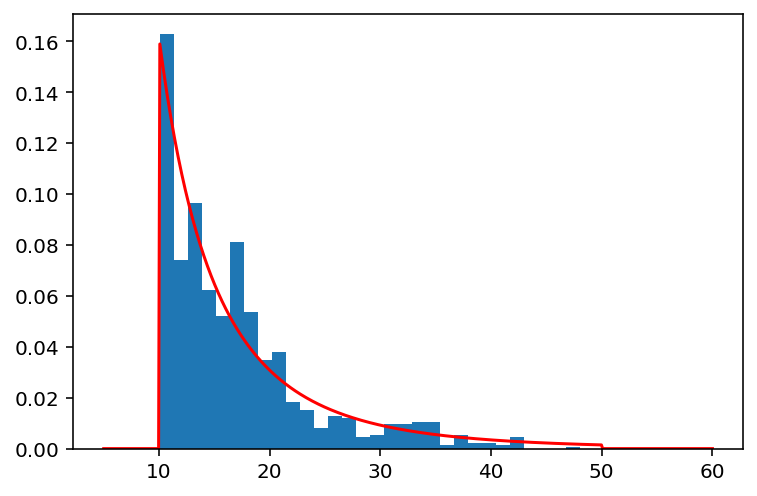

In [54]:
xs = np.linspace(a/2, 60, 500)
plt.hist(X, 30, density=True);
plt.plot(xs, π(xs) / πConst, 'r');

In contrast, we can easily go too far, and accept too few samples.

In [55]:
%%time 

rng = rnd.default_rng(1)
R = 10**3

X = np.empty(R)
X[0] = 25

jumps = rng.normal(scale=100, size=R-1)
uniforms = rng.uniform(size=R-1)

for n in trange(1, R):
    Y = X[n-1] + jumps[n-1]
    
    α = π(Y) / π(X[n-1])
    
    if uniforms[n-1] < α:
        X[n] = Y
    else:
        X[n] = X[n-1]
        
acceptRate = np.mean(np.diff(X) != 0.0)
print(f"We accepted {acceptRate*100:.2f}% of proposals")


We accepted 7.11% of proposals
Wall time: 39 ms


C:\Users\patri\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


In [56]:
az.stats.ess(X)

37.29823712754565

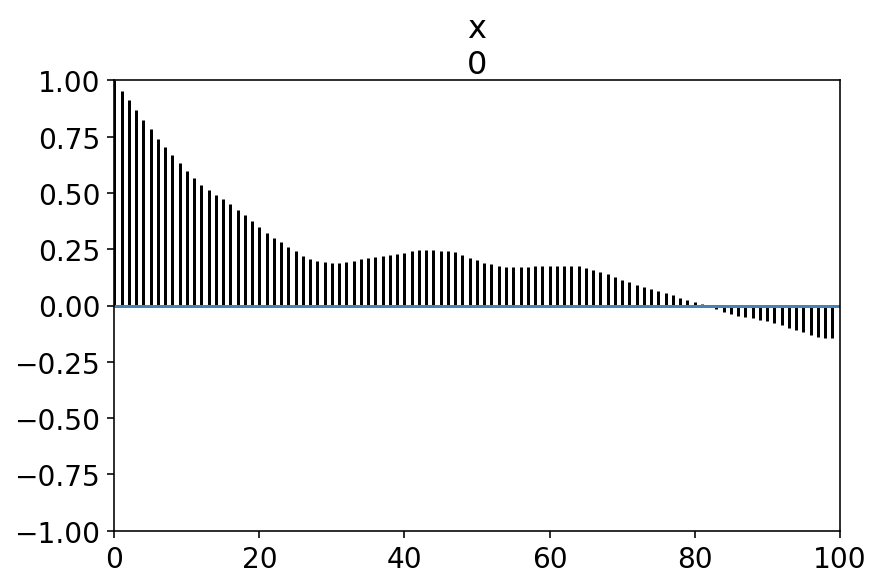

In [57]:
az.plot_autocorr(X);

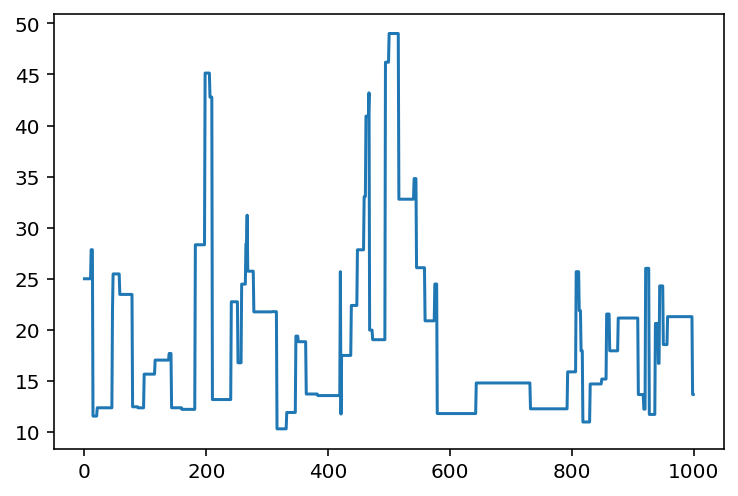

In [58]:
plt.plot(X);

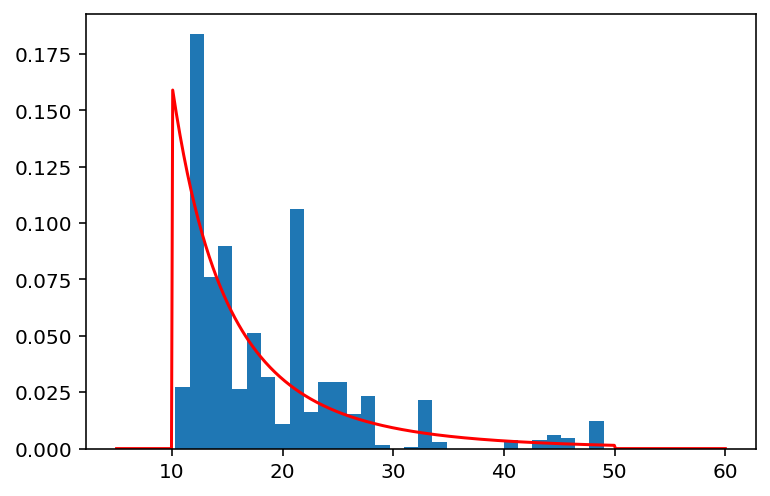

In [59]:
xs = np.linspace(a/2, 60, 500)
plt.hist(X, 30, density=True);
plt.plot(xs, π(xs) / πConst, 'r');

As a reference, this is what 1000 i.i.d. variables from this distribution look like.

In [60]:
rng = rnd.default_rng(1)

uniforms = rng.uniform(
    low = stats.weibull_min.cdf(a, c=0.5),
    high = stats.weibull_min.cdf(b, c=0.5),
    size = 1000)

X = stats.weibull_min.isf(1-uniforms, c=0.5);

In [61]:
az.stats.ess(X)

909.4100173671438

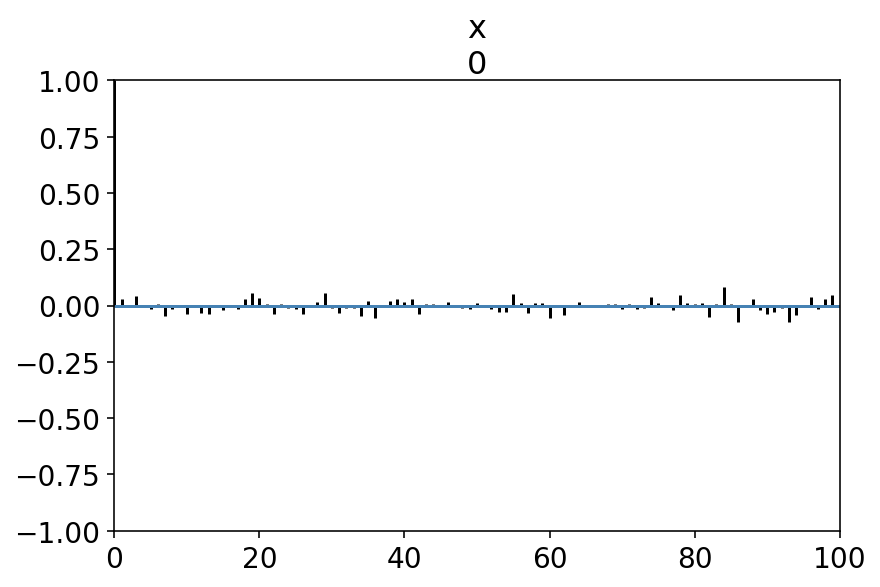

In [62]:
az.plot_autocorr(X);

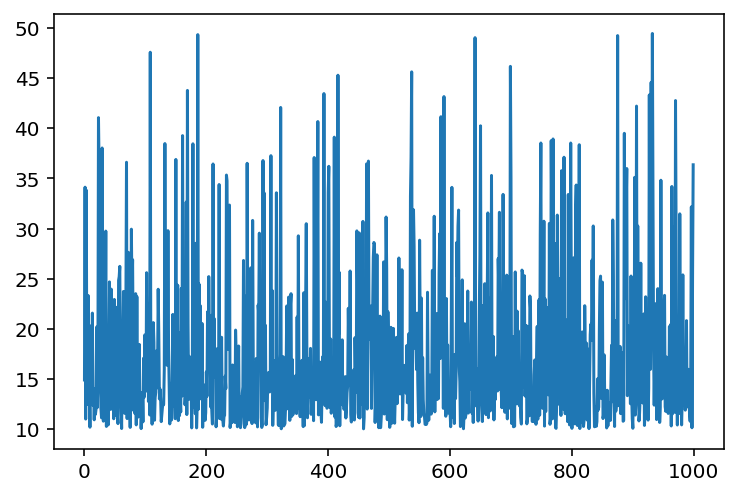

In [63]:
plt.plot(X);

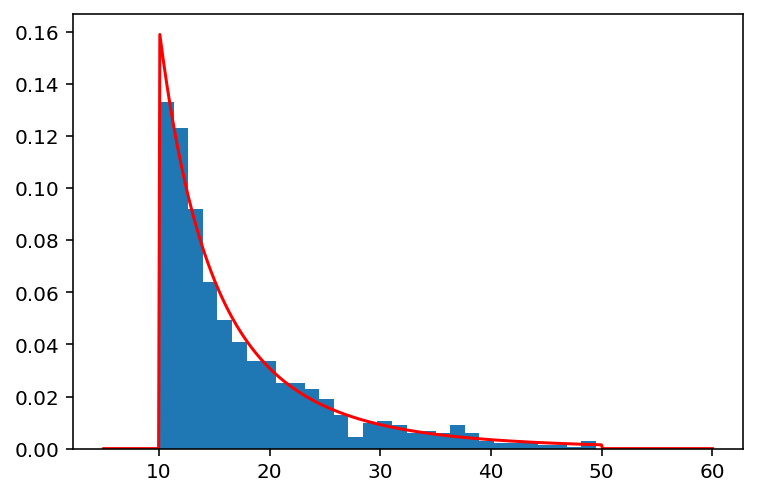

In [64]:
x = np.linspace(a/2, 60, 500)
plt.hist(X, 30, density=True);
plt.plot(xs, π(x) / πConst, 'r');

#### Reducing dependence by subsampling

In [65]:
%%time 

rng = rnd.default_rng(1)
R = 10**5

X = np.empty(R)
X[0] = 25

jumps = rng.normal(size=R-1)
uniforms = rng.uniform(size=R-1)

for n in trange(1, R):
    Y = X[n-1] + jumps[n-1]
    
    α = π(Y) / π(X[n-1])
    
    if uniforms[n-1] < α:
        X[n] = Y
    else:
        X[n] = X[n-1]


Wall time: 1.41 s


In [66]:
Xsub = X[::100]
len(X), len(Xsub)

(100000, 1000)

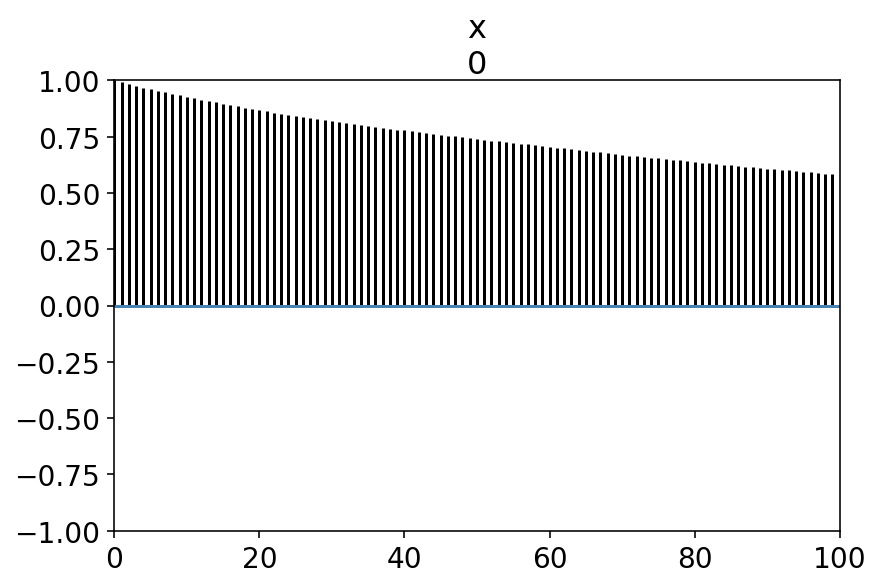

In [67]:
az.plot_autocorr(X);

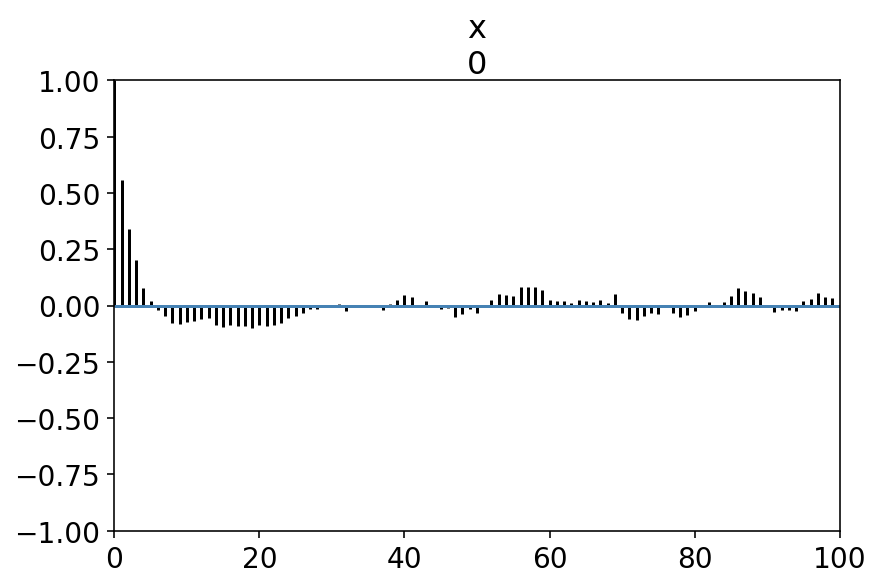

In [68]:
az.plot_autocorr(Xsub);

In [69]:
az.stats.ess(X) / R

0.004318650176653973

In [70]:
az.stats.ess(Xsub) / (R / 100)

0.40434897699671135

In [71]:
az.stats.ess(X)

431.86501766539726

In [72]:
az.stats.ess(Xsub)

404.3489769967114